# RNN

### Import thư viện

In [1]:
# import thư viện
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

## Bitcoin Dataset

In [4]:
file_path = "C:\\Users\\Hii\\Documents\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\Ethereum Historical Data.csv"

data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_values('Date', inplace=True)

## Chia 7:3

In [5]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.7)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [23]:
dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [24]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1195
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8103e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5501e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9943e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0742e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3385e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6090e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7517e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8241e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9616e-04
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5461e-04
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3176e-04
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4642e-04
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━

In [25]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

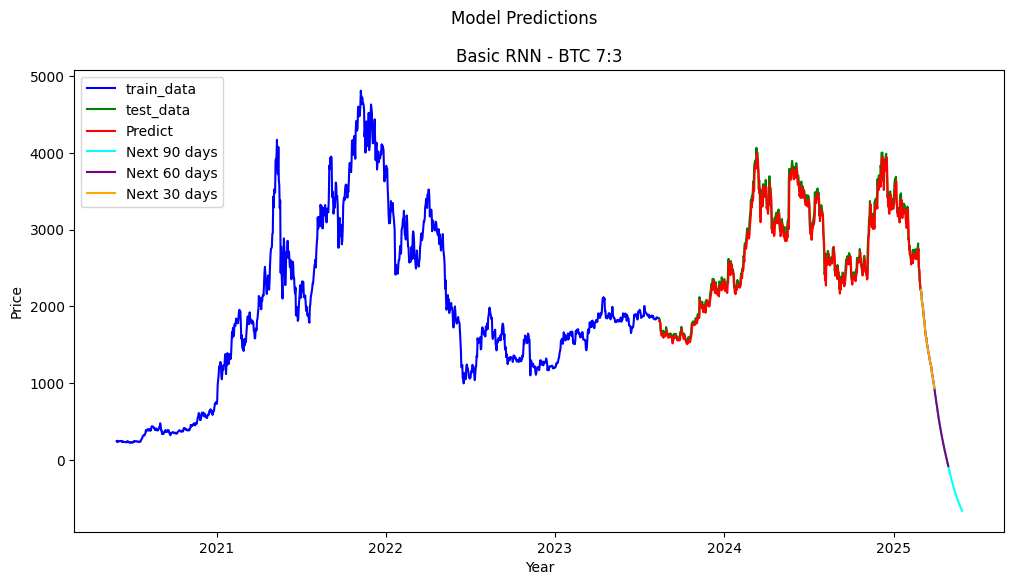

In [28]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 106.17094347756448
MAPE: 2.784593728715208 %
MSE: 11272.269238916191
